# Time Series Analysis

Questo notebook analizza le tendenze che influenzano le vendite di liqour nello stato dell'Iowa, in America, e mira a prevedere il confronto delle performance dei marchi concorrenti.

Utilizzeremo "Time Series Analysis" per estrarre le tendenze e costruire modelli "Auto Regressive Integrated Moving Average" (ARIMA) per produrre previsioni.

# Import the libraries and Read CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
plt.style.use('ggplot')
from scipy import stats
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [3]:
df = pd.read_csv("C:/Users/gigio/Downloads/Iowa_Liquor_Sales.csv", low_memory=False)

In [4]:
#ETL per eliminare i valori nulli ed i duplicati
df.dropna(inplace=True)
df.drop_duplicates(inplace = True)
# df.shape
df.isnull().sum() #verifica che sono stati eliminati i valori nulli

Invoice/Item Number      0
Date                     0
Store Number             0
Store Name               0
Address                  0
City                     0
Zip Code                 0
Store Location           0
County Number            0
County                   0
Category                 0
Category Name            0
Vendor Number            0
Vendor Name              0
Item Number              0
Item Description         0
Pack                     0
Bottle Volume (ml)       0
State Bottle Cost        0
State Bottle Retail      0
Bottles Sold             0
Sale (Dollars)           0
Volume Sold (Liters)     0
Volume Sold (Gallons)    0
dtype: int64

In [5]:
df['Vendor Name']=df['Vendor Name'].str.upper()

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

Vendor Name
DIAGEO AMERICAS                     29544585
JIM BEAM BRANDS                     13778927
SAZERAC COMPANY  INC                13590677
SAZERAC NORTH AMERICA               10640903
LUXCO-ST LOUIS                      10074553
LUXCO INC                            8460974
HEAVEN HILL BRANDS                   7243152
CONSTELLATION WINE COMPANY, INC.     7220819
CONSTELLATION BRANDS INC             6396479
PROXIMO                              5643107
Name: Bottles Sold, dtype: int64


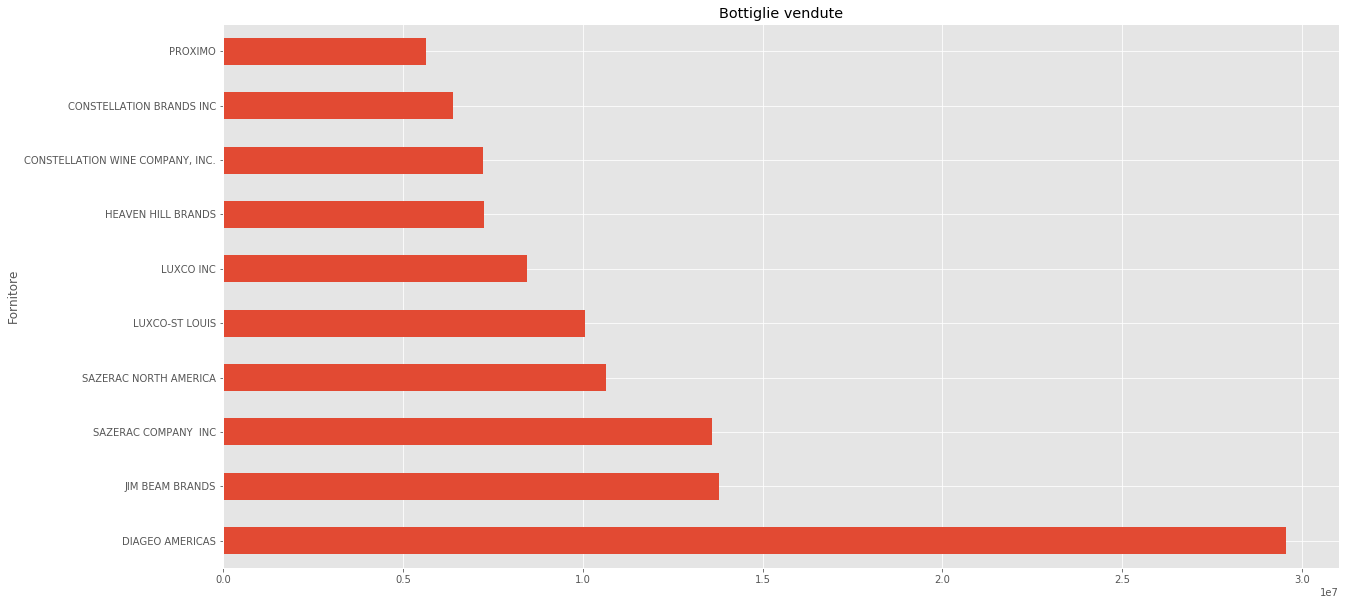

In [36]:
#aggiunta 
print(df.groupby('Vendor Name')['Bottles Sold'].sum().sort_values(ascending=False).head(10))
df.groupby('Vendor Name')['Bottles Sold'].sum().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(20,10))
plt.ylabel('Fornitore')
plt.title('Bottiglie vendute')
plt.show()

# Data Preprocessing

In [7]:
## Data Preprocessing
DA = df.loc[df['Vendor Name'] == 'DIAGEO AMERICAS']
cols = ['Invoice/Item Number', 'Store Number', 'Store Name', 'Address', 'City', 'Zip Code',
       'Store Location', 'County Number', 'County', 'Category', 'Category Name', 'Vendor Number',
       'Vendor Name', 'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost',
        'State Bottle Retail', 'Bottles Sold', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']
DA.drop(cols, axis = 1, inplace = True)
DA.isnull().sum()

DA = DA.groupby('Date')['Sale (Dollars)'].sum().reset_index()
DA = DA.set_index('Date')
DA.index

C:\Users\gigio\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-09',
               '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-16',
               '2012-01-17', '2012-01-18',
               ...
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-27',
               '2020-11-28', '2020-11-30'],
              dtype='datetime64[ns]', name='Date', length=2135, freq=None)

Trend Extraction

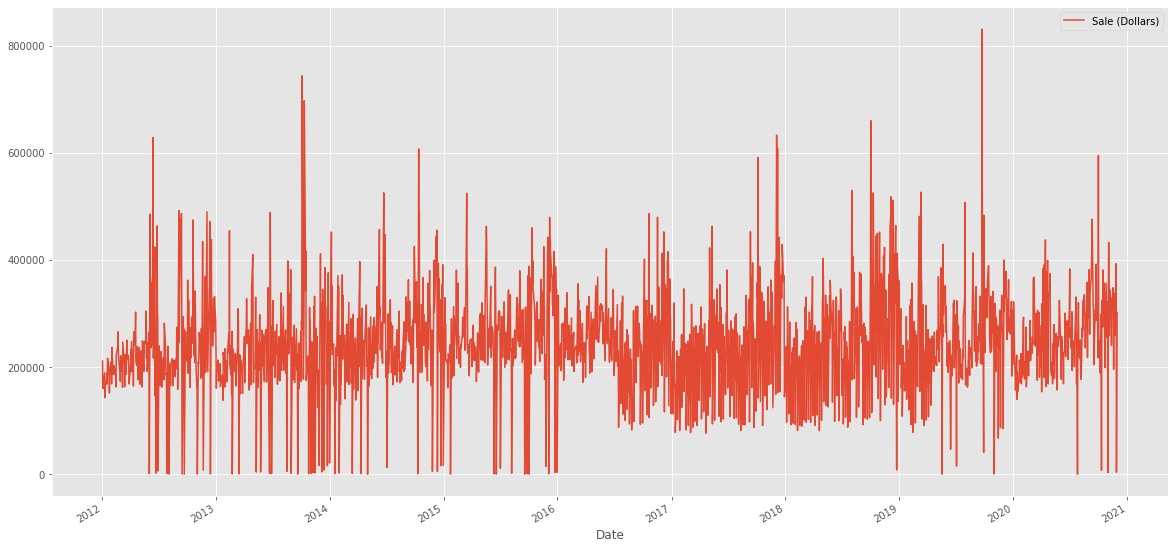

In [8]:
DA.plot(figsize=(20,10));


I nostri dati datetime correnti possono essere difficili da lavorare, pertanto, utilizzeremo invece il valore medio delle vendite giornaliere per quel mese e utilizzeremo l'inizio di ogni mese come timestamp.

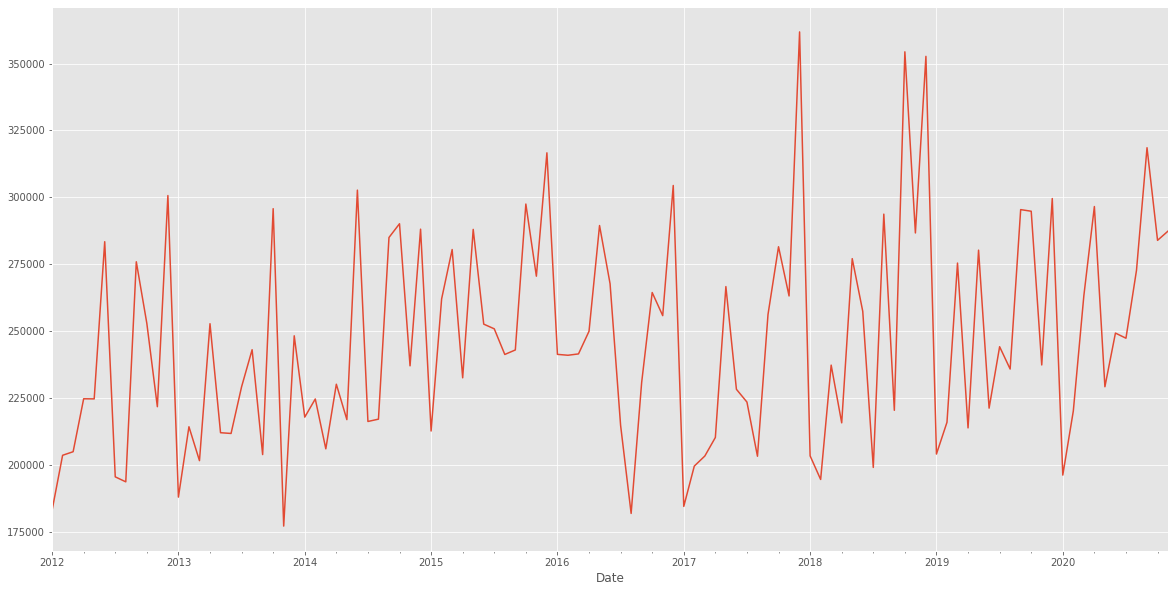

In [9]:
## Time Series Analysis
#RESAMPLE RICAMPIONA I DATI DELLE SERIE TEMPORALI, IN QUESTO MODO VEDO LE VENDITE DI DIAGEO AMERICAS NEL TEMPO
DA.head()
y = DA['Sale (Dollars)'].resample('MS').mean()
y['2012':].describe()
y.plot(figsize=(20,10))

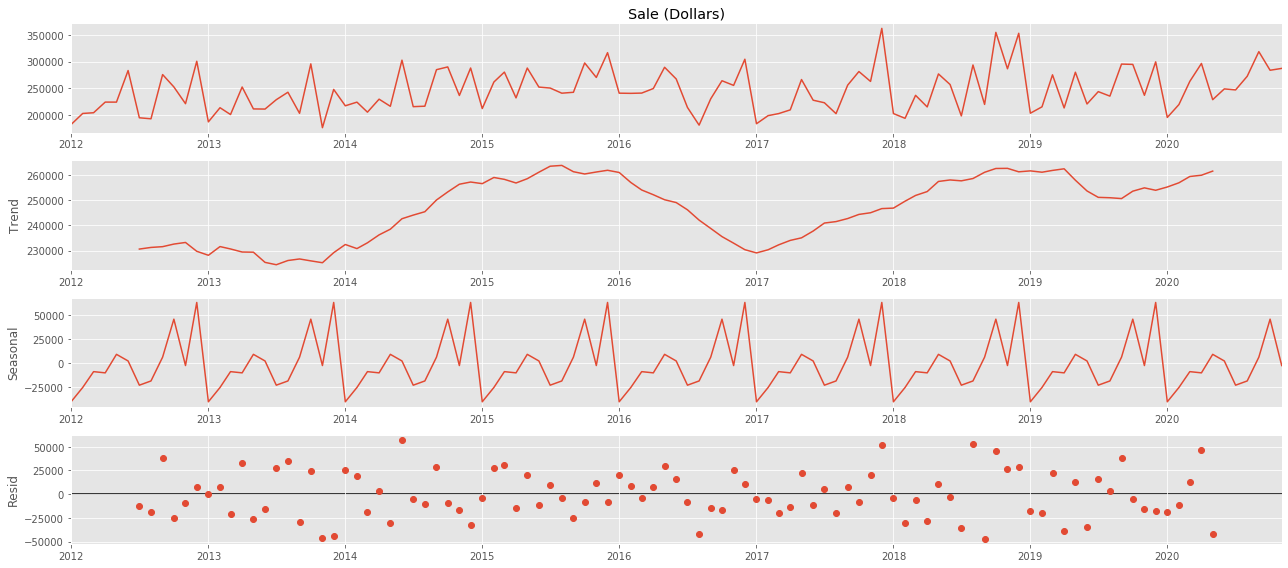

In [10]:
#Decomposizione stagionale utilizzando medie mobili, tramite sm.tsa.seasonal_decompose.
#passo y, in quanto è la mia serie e il tipo di componente stagionale setto additivo
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()

Notiamo come le vendite di Diageo Americas, su tutta la finestra temporale della serie, mostrano un aumento interessante solo a partire all’ultimo trimestre del 2013 e fino all’anno 2016, raggiungendo picchi tra il 2015 e il 2016. Notiamo invece come sia stato un anno negativo per le vendite il 2016, in quanto i valori scendono a numeri precedenti l’anno 2014. Dal 2017, il trend delle vendite torna a crescere e si mantiene alto e costante negli anni. Si mostra solo una leggera diminuzione a cavallo tra il secondo e terzo trimestre dell’anno contrastata però da una nuova crescita a partire dall’ultimo trimestre dello stesso anno.
Sembra anche che le vendite abbiano una periodicità di 12 mesi. In particolare, notiamo come sia presente quindi una stagionalità con picchi nell'ultimo trimestre di ogni anno.

Modellazione ARIMA
Prima di iniziare la costruzione del modello ARIMA, dobbiamo selezionare i parametri ottimali (p, d, q, t). Poiché abbiamo già stabilito che la periodicità è di 12 mesi, possiamo lasciare t = 12. Per determinare le stime per p, d & q, simuleremo tutte le combinazioni dei parametri e selezioneremo il modello con il punteggio AIC più basso.

In [11]:
# Parameter Tuning
import itertools
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))  
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2937.882503897526
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2551.2551579343094
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2258.5653436084126
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1961.058881248007
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2282.681901786254
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2254.4492024305123
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1974.4569886449076
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1952.4604533217037
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2847.925151738088
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2506.562668400234
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2235.8232916331244
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1940.2356188988474
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2544.9905719078397
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2493.388443278339
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1978.4744358556445
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1933.7516477787105
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2593.1966491251733
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2287.327748639323

Creo tre variabili denominate p, d e q e le imposto su un intervallo compreso tra 0 e 2. Quindi utilizzare il metodo del prodotto itertools per trovare tutte le possibili combinazioni di p, d e q e le imposto su una variabile. Quindi, un ciclo for quando si chiama il metodo ARIMA per scorrere ogni combinazione di p, d e q. Trovati i modelli AIC si aggiungono alla lista degli AIC e aggiorna il dizionario con ogni modello AIC e il set di parametri utilizzati. Infine, trova il valore minimo nell'elenco degli AIC e poi trova quella chiave nel dizionario. La chiave risultante sarà l'ordine ottimale con cui creare un modello.

Per eseguire un modello ARIMA ci sono due argomenti: i dati effettivi e l'ordine. L'ordine è una tupla contenente p, d e q. Per eseguire il modello è sufficiente creare un'istanza di oggetto ARIMA dalla classe in statsmodels.tsa.arima_model. Impostare gli argomenti (dati e ordine) durante l'istanza e quindi adattare il modello chiamando ".fit ()" farlo per ogni combinazione di argomenti e salvare l'AIC negli elenchi e nei dizionari menzionati sopra. Per trovare l'AIC del modello è sufficiente prendere la variabile di istanza del modello e chiamare ".aic" per restituire l'AIC. Di seguito è riportato un esempio di costruzione di un modello ARIMA.

il modello ottimo lo si ha per:

prendo --> ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1928.7682756764023 in quanto ha i più bassi valori di AIC

Utilizzando la ricerca griglia, abbiamo identificato l'insieme di parametri che produce il modello più adatto ai dati delle nostre serie temporali. Possiamo procedere ad analizzare questo particolare modello in modo più approfondito.

Inizieremo inserendo i valori dei parametri ottimali in un nuovo SARIMAXmodello:

# SARIMAX Model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9383      0.023     41.580      0.000       0.894       0.983
ma.L1         -0.8475      0.103     -8.222      0.000      -1.049      -0.645
ma.S.L12      -0.4484      0.153     -2.937      0.003      -0.748      -0.149
sigma2      1.543e+09   9.99e-12   1.54e+20      0.000    1.54e+09    1.54e+09


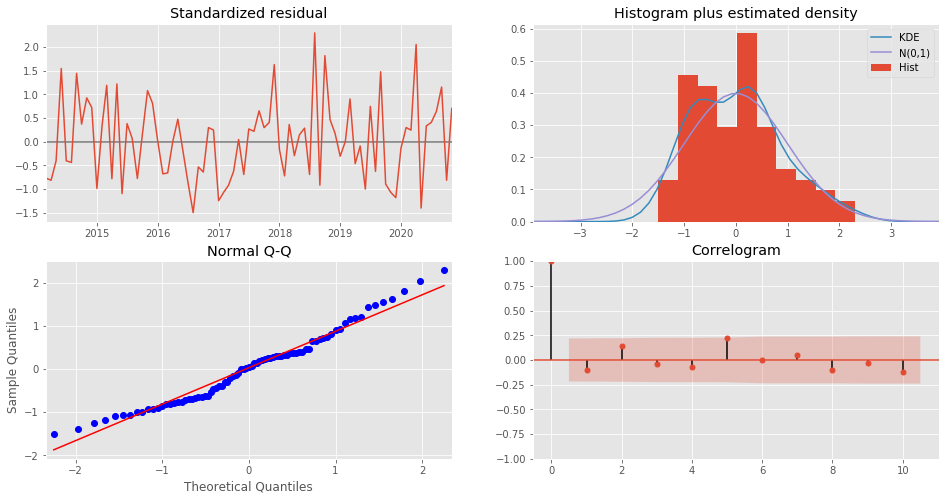

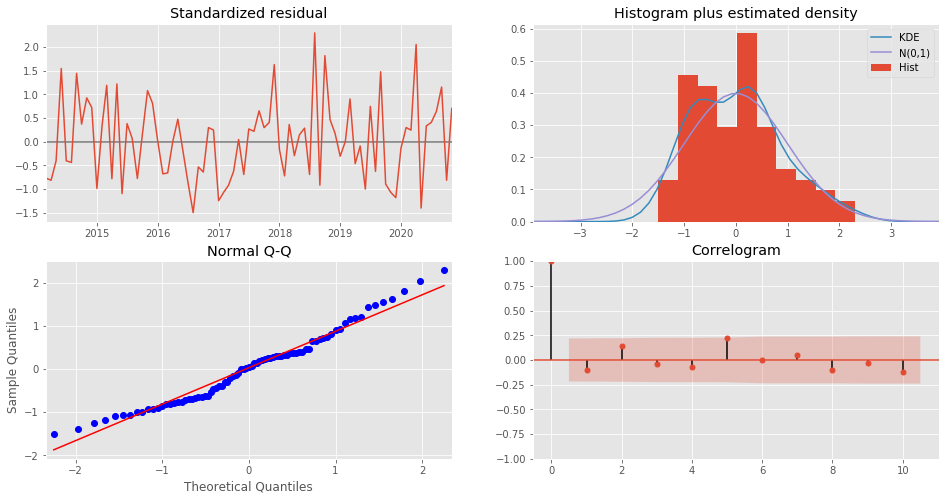

In [12]:
# Fitting Model
mod = sm.tsa.statespace.SARIMAX(y,
                                order = (1,0,1),
                                seasonal_order = (0,1,1,12),
                                enforce_stationarity = False, #Se trasformare o meno i parametri AR per imporre la stazionarietà nella componente autoregressiva del modello.
                                enforce_invertibility = False) #Se trasformare o meno i parametri MA per rafforzare l'invertibilità nella componente media mobile del modello.

results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize = (16,8))

Il summary risultante dall'output di SARIMAX restituisce una notevole quantità di informazioni, ma focalizzeremo la nostra attenzione sulla tabella dei coefficienti. La colonna coeff mostra il peso (ovvero l'importanza) di ogni caratteristica e il modo in cui ciascuna di esse influisce sulla serie temporale. La colonna P>|z| ci informa del significato di ogni peso della caratteristica. In questo caso, ogni peso ha un valore p inferiore o vicino a 0.05, quindi è ragionevole mantenerli tutti nel nostro modello.

Quando si adattano i modelli ARIMA stagionali è importante eseguire la diagnostica del modello. L'oggetto plot_diagnostics ci consente di generare rapidamente la diagnostica del modello e di indagare su qualsiasi comportamento insolito.

La nostra preoccupazione principale è garantire che i residui del nostro modello non siano correlati e normalmente distribuiti con media zero. Se il modello ARIMA stagionale non soddisfacesse queste proprietà, sarebbe stato bene migliorare il modello.

In questo caso, la nostra diagnostica del modello suggerisce che i residui del modello sono normalmente distribuiti in base a quanto segue:

-Nel grafico in alto a destra, vediamo che la KDE segue strettamente con la N(0,1)linea (dove N(0,1)) è la notazione standard per una distribuzione normale con media 0 e deviazione standard di 1). Questa è una buona indicazione che i residui sono normalmente distribuiti.

-Il grafico in basso a sinistra, mostra che la distribuzione ordinata dei residui (punti blu) segue l'andamento lineare dei campioni presi da una distribuzione normale standard con N(0, 1). Ancora una volta, questa è una forte indicazione che i residui sono normalmente distribuiti.

-I residui nel tempo (grafico in alto a sinistra) non mostrano alcuna stagionalità evidente e sembrano essere rumore bianco. 

-Ciò è confermato dal grafico di autocorrelazione (cioè correlogramma) in basso a destra, che mostra che i residui delle serie temporali hanno una bassa correlazione con le versioni ritardate di se stesse.

Queste osservazioni ci portano a concludere che il nostro modello produce un adattamento soddisfacente che potrebbe aiutarci a comprendere i dati delle nostre serie temporali e prevedere i valori futuri.

# VALIDATION

Abbiamo ottenuto un modello per le nostre serie temporali che ora può essere utilizzato per produrre previsioni. Iniziamo confrontando i valori previsti con i valori reali delle serie temporali, che ci aiuteranno a comprendere l'accuratezza delle nostre previsioni. Gli attributi get_prediction()e conf_int()ci consentono di ottenere i valori e gli intervalli di confidenza associati per le previsioni delle serie temporali.

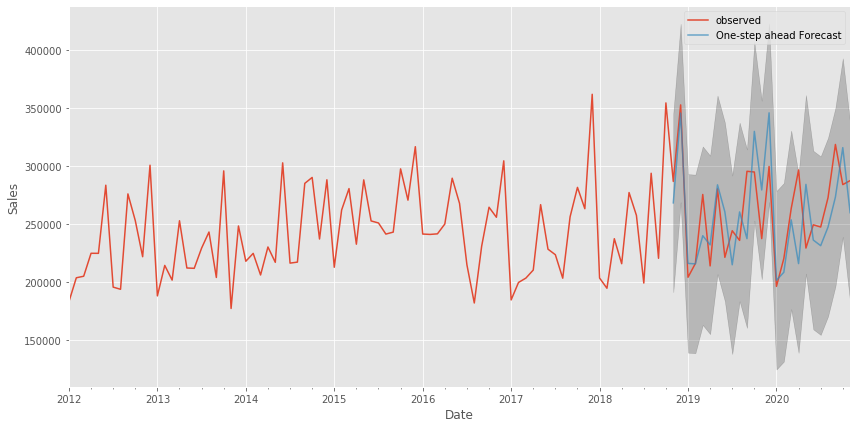

In [13]:
# Validation
pred = results.get_prediction(start=pd.to_datetime('2018-11-01'), dynamic=False) #start= Numero di osservazione indicizzato a zero dal quale iniziare la previsione
pred_ci = pred.conf_int()
ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

Esprimo l'errore in MAPE, media degli errori percentuali assoluti

In [30]:
y_forecasted = pred.predicted_mean #qui metto le y predette
y_truth = y['2018-11-01':] #tutte le osservazioni corrispondono alle y vere

In [31]:
print("y_truth shape = " , y_truth.shape)
print("y_predicted shape = " , y_forecasted.shape)

y_truth shape =  (25,)
y_predicted shape =  (25,)


In [32]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [33]:
mape = mape(y_truth, y_forecasted)
print(mape)

10.44680759529301


# Forecasting

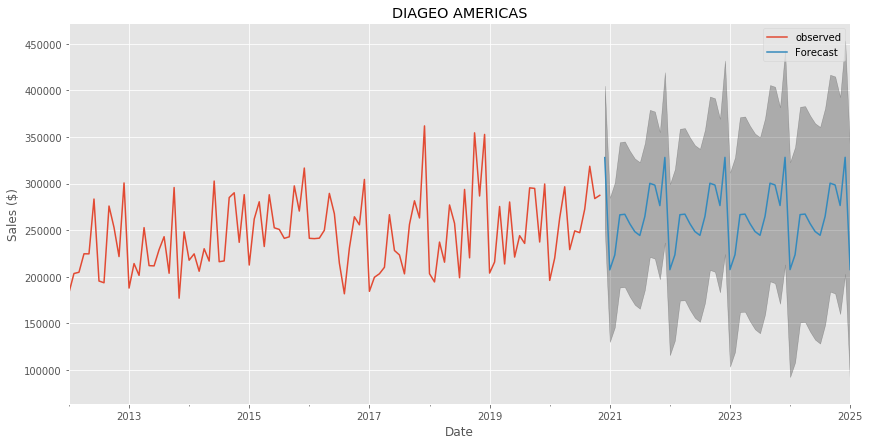

In [33]:
# Forecasting
pred_uc = results.get_forecast(steps=50) #step inizalmente=30 per 3 anni, setp 50 per 5 anni
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales ($)')
ax.set_title('DIAGEO AMERICAS')
plt.legend()

Comparing Brands

In [26]:
## Comparing Brands
JBB= df.loc[df['Vendor Name'] == 'JIM BEAM BRANDS']
DA = df.loc[df['Vendor Name'] == 'DIAGEO AMERICAS']

DA.drop(cols, axis = 1, inplace = True)
JBB.drop(cols, axis = 1, inplace = True)
DA.isnull().sum()
JBB.isnull().sum()

DA = DA.groupby('Date')['Sale (Dollars)'].sum().reset_index()
JBB = JBB.groupby('Date')['Sale (Dollars)'].sum().reset_index()
DA = DA.set_index('Date')
JBB = JBB.set_index('Date')
DA.index
JBB.index

C:\Users\gigio\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-09',
               '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-16',
               '2012-01-17', '2012-01-18',
               ...
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-27',
               '2020-11-28', '2020-11-30'],
              dtype='datetime64[ns]', name='Date', length=2131, freq=None)

In [27]:
y_DA = DA['Sale (Dollars)'].resample('MS').mean()
y_JBB = JBB['Sale (Dollars)'].resample('MS').mean()
DA = pd.DataFrame({'Date': y_DA.index, 'Sale (Dollars)': y_DA.values})
JBB = pd.DataFrame({'Date': y_JBB.index, 'Sale (Dollars)': y_JBB.values})

vendor = DA.merge(JBB, how = 'inner', on = 'Date')
vendor.rename(columns = {'Sale (Dollars)_x': 'DIAGEO AMERICAS', 'Sale (Dollars)_y': 'JIM BEAM BRANDS'}, inplace = True)
vendor.head()

,Date,DIAGEO AMERICAS,JIM BEAM BRANDS
0,2012-01-01,182981.287059,82680.970588
1,2012-02-01,203553.833529,82384.854706
2,2012-03-01,204885.607647,77040.698889
3,2012-04-01,224681.446471,89337.144118
4,2012-05-01,224635.786316,87458.327895


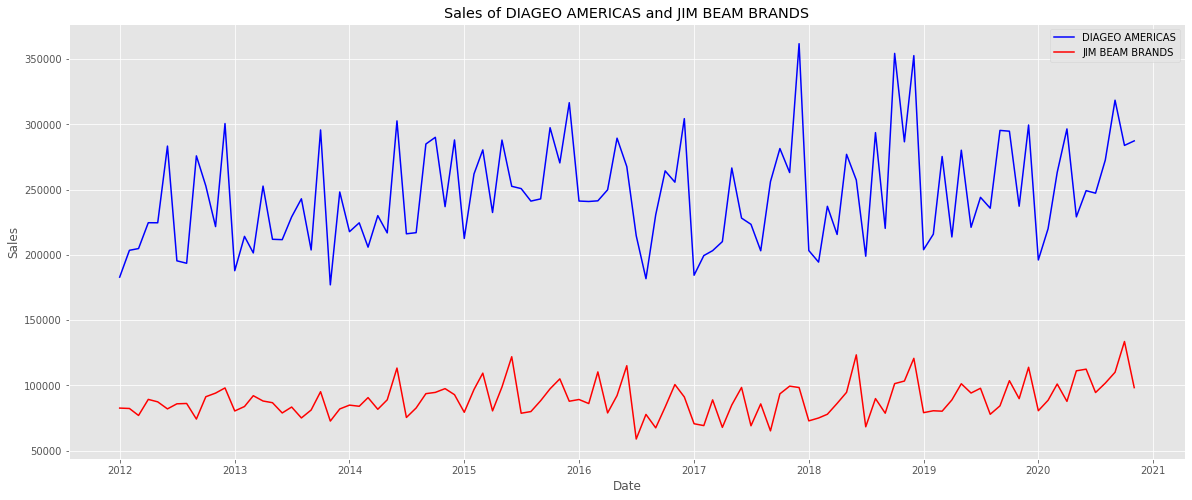

In [35]:
plt.figure(figsize=(20,8))
plt.plot(vendor['Date'], vendor['DIAGEO AMERICAS'], 'b-', label = 'DIAGEO AMERICAS')
plt.plot(vendor['Date'], vendor['JIM BEAM BRANDS'], 'r-', label = 'JIM BEAM BRANDS')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of DIAGEO AMERICAS and JIM BEAM BRANDS')
plt.legend()

Previsioni con Prophet
Utilizzando il pacchetto Prophet, siamo in grado di generare previsioni più accurate senza dover passare attraverso il fastidio di costruire manualmente il modello ARIMA.

# Forecasting with Prophet

“Prophet è una procedura per la previsione dei dati di serie temporali basata su un modello additivo in cui le tendenze non lineari si adattano alla stagionalità annuale, settimanale e giornaliera, oltre agli effetti delle festività. Funziona meglio con le serie temporali che hanno forti effetti stagionali e diverse stagioni di dati storici. Prophet è resistente ai dati mancanti e ai cambiamenti di tendenza e in genere gestisce bene i valori anomali.”

In [36]:
## Forecasting attraverso la libreria Prophet
from fbprophet import Prophet

DA = DA.rename(columns = {'Date': 'ds', 'Sale (Dollars)': 'y'})
DA_model = Prophet(interval_width = 0.95)
DA_model.fit(DA)

JBB = JBB.rename(columns = {'Date': 'ds', 'Sale (Dollars)': 'y'})
JBB_model = Prophet(interval_width = 0.95)
JBB_model.fit(JBB)

DA_forecast = DA_model.make_future_dataframe(periods=36, freq = 'MS')  ##period 36 sono i mesi e quindi 3 anni da fine 2020 a 2023
DA_forecast = DA_model.predict(DA_forecast)

JBB_forecast = JBB_model.make_future_dataframe(periods = 36, freq = 'MS')
JBB_forecast = JBB_model.predict(JBB_forecast)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'DIAGEO AMERICAS with Forecasts')

<Figure size 1440x720 with 0 Axes>

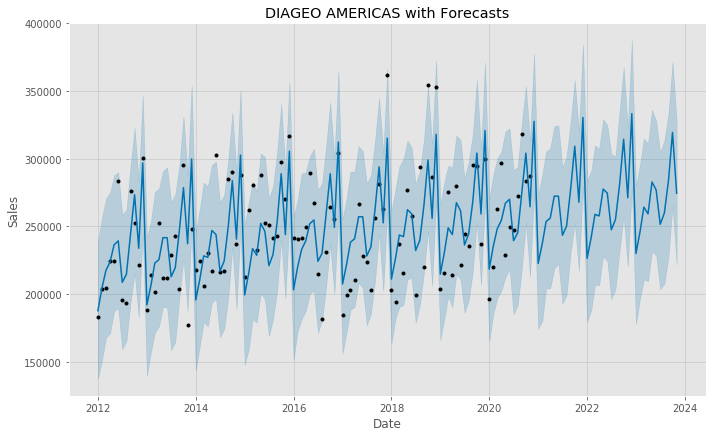

In [39]:
plt.figure(figsize=(20,10))
DA_model.plot(DA_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('DIAGEO AMERICAS with Forecasts')

Text(0.5, 1, 'JEAM BEAM BRANDS Sales with Forecasts')

<Figure size 1440x720 with 0 Axes>

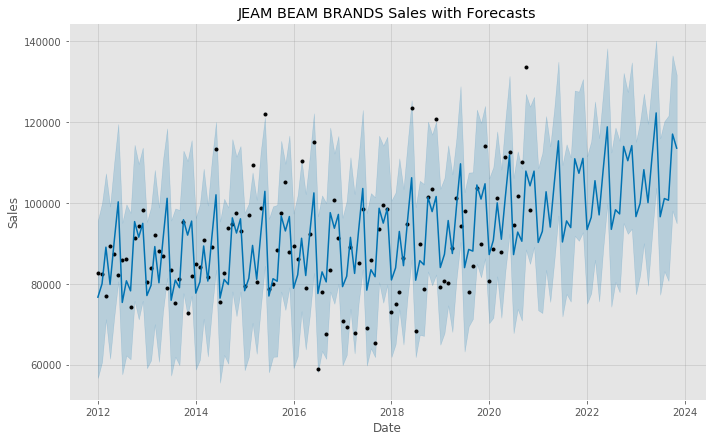

In [40]:
plt.figure(figsize=(20,10))
JBB_model.plot(JBB_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('JEAM BEAM BRANDS Sales with Forecasts')

Notiamo dal grafico che la previsione per questo marchio mostra sicuramente una crescita e quindi un incremento delle vendite nei prossimi tre anni. Anche per questo marchio si rilevano dei picchi che interessano gli ultimi mesi di ogni anno. Stando alla previsione, possiamo dedurre che nell’ultimo trimestre dell’anno 2023, Jim Beam Brands potrebbe vantare di incassi che raggiungo oltre 120.000 dollari a fronte degli ultimi anni in cui nei migliori periodi si registrano poco più di 100.000 dollari.

In [41]:
DA_names = ['DA_%s' % column for column in DA_forecast.columns]
JBB_names = ['JBB_%s' % column for column in JBB_forecast.columns]

merge_DA_forecast = DA_forecast.copy()
merge_JBB_forecast = JBB_forecast.copy()
merge_DA_forecast.columns = DA_names
merge_JBB_forecast.columns = JBB_names

forecast = pd.merge(merge_DA_forecast, merge_JBB_forecast, how = 'inner', left_on = 'DA_ds', right_on = 'JBB_ds')
forecast = forecast.rename(columns = {'DA_ds': 'Date'}).drop('JBB_ds', axis = 1)
forecast.head()

,Date,DA_trend,DA_yhat_lower,DA_yhat_upper,DA_trend_lower,DA_trend_upper,DA_additive_terms,DA_additive_terms_lower,DA_additive_terms_upper,DA_yearly,...,JBB_additive_terms,JBB_additive_terms_lower,JBB_additive_terms_upper,JBB_yearly,JBB_yearly_lower,JBB_yearly_upper,JBB_multiplicative_terms,JBB_multiplicative_terms_lower,JBB_multiplicative_terms_upper,JBB_yhat
0,2012-01-01,229329.253812,137401.851445,239063.841384,229329.253812,229329.253812,-41599.179767,-41599.179767,-41599.179767,-41599.179767,...,-9255.678947,-9255.678947,-9255.678947,-9255.678947,-9255.678947,-9255.678947,0.0,0.0,0.0,76680.154287
1,2012-02-01,229658.395608,151454.333459,256818.379455,229658.395608,229658.395608,-24837.509458,-24837.509458,-24837.509458,-24837.509458,...,-5994.505343,-5994.505343,-5994.505343,-5994.505343,-5994.505343,-5994.505343,0.0,0.0,0.0,79988.221367
2,2012-03-01,229966.302450,167711.276658,270305.129673,229966.302450,229966.302450,-12522.757274,-12522.757274,-12522.757274,-12522.757274,...,3015.052068,3015.052068,3015.052068,3015.052068,3015.052068,3015.052068,0.0,0.0,0.0,89041.646868
3,2012-04-01,230295.444246,171031.973902,275132.894505,230295.444246,230295.444246,-6438.501713,-6438.501713,-6438.501713,-6438.501713,...,-6254.121179,-6254.121179,-6254.121179,-6254.121179,-6254.121179,-6254.121179,0.0,0.0,0.0,79819.367097
4,2012-05-01,230613.968578,187535.397071,287682.080093,230613.968578,230613.968578,5853.728026,5853.728026,5853.728026,5853.728026,...,4069.477778,4069.477778,4069.477778,4069.477778,4069.477778,4069.477778,0.0,0.0,0.0,90188.346832


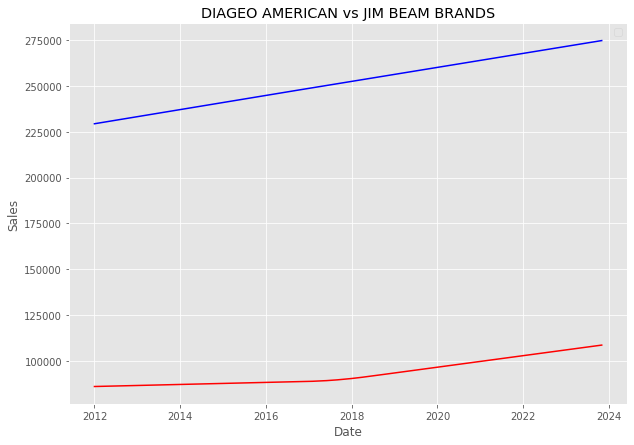

In [42]:
plt.figure(figsize = (10,7))
plt.plot(forecast['Date'], forecast['DA_trend'], 'b-')
plt.plot(forecast['Date'], forecast['JBB_trend'], 'r-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('DIAGEO AMERICAN vs JIM BEAM BRANDS')
plt.legend()

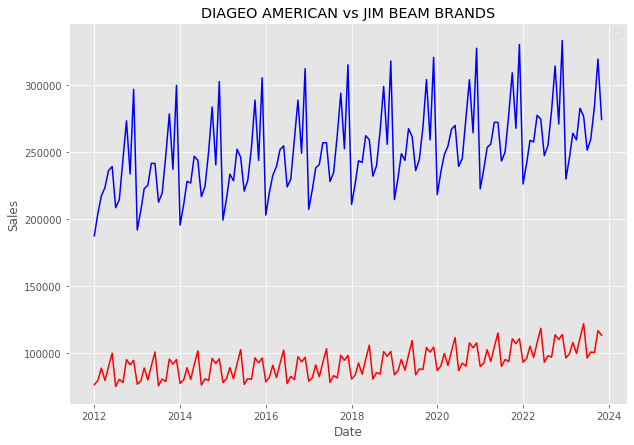

In [44]:
plt.figure(figsize=(10,7))
plt.plot(forecast['Date'], forecast['DA_yhat'], 'b-')  #yhat è la previsione fatto dal modello con Prophet
plt.plot(forecast['Date'], forecast['JBB_yhat'], 'r-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('DIAGEO AMERICAN vs JIM BEAM BRANDS')
plt.legend()

# Iowa Liquor Market

In [35]:
df1 =df.copy()

In [36]:

df1.drop(cols, axis = 1, inplace = True)
df1 = df1.groupby('Date')['Sale (Dollars)'].sum().reset_index()
df1 = df1.set_index('Date')
y = df1['Sale (Dollars)'].resample('MS').mean()

df1 = pd.DataFrame({'Date': y.index, 'Sale (Dollars)': y.values})
df1 = df1.rename(columns ={'Date': 'ds', 'Sale (Dollars)': 'y'} )
df1_model = Prophet(interval_width = 0.95)
df1_model.fit(df1)

df1_forecast = df1_model.make_future_dataframe(periods = 36, freq = 'MS')
df1_forecast = df1_model.predict(df1_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1, 'Liquor Market')

<Figure size 1296x432 with 0 Axes>

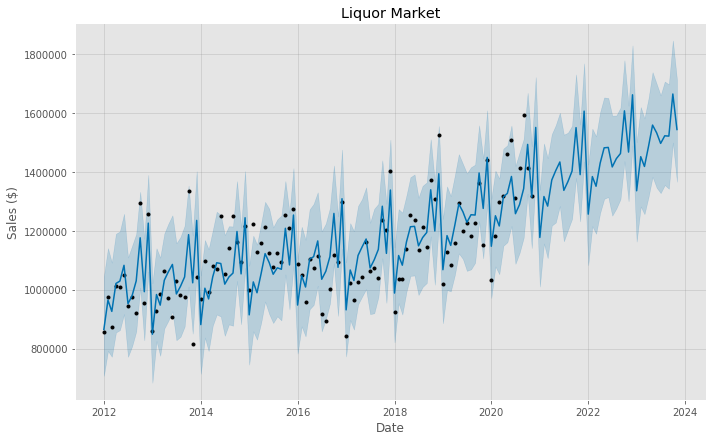

In [37]:
plt.figure(figsize = (18,6))
df1_model.plot(df1_forecast, xlabel = 'Date', ylabel = 'Sales ($)')
plt.title('Liquor Market')

Dunque, si può concludere che il mercato dei liquori relativo allo stato dell’Iowa è un settore in crescita. Vediamo dalla curva di previsione come i valori predetti delle vendite siano in aumento e con picchi sempre in prossimità dell’ultimo trimestre.